# Intro

Basic terms related to Confusion matrix:

* <b>True positives (TP):</b> These are cases in which we predicted yes (employees will leave the organisation), and employees actually leave i.e 100
* <b>True negatives (TN):</b> We predicted no(employees will not leave the organisation) and they don’t leave i.e 50
* <b>False positives (FP):</b> We predicted yes they will leave, but they don’t leave. (Also known as a “Type I error.”) i.e 10
* <b>False negatives (FN):</b> We predicted no they will not leave, but they actually leave (Also known as a “Type II error.”) i.e 5

Evaluating a Classification Model
* <b>Accuracy :</b> (TP+TN)/Total . Describes overall, how often the classifier correct. i.e 100+50/165 Measures of Accuracy

Sensitivity and specificity are statistical measures of the performance of a binary classification test:

* <b>Sensitivity/Recall =</b> TP/(TP + FN). When it’s actually yes, how often does it predict yes? i.e 100/(100+5)
* <b>Specificity =</b> TN/(TN + FP).When it’s actually no, how often does it predict no?? i.e 50/(50+10)
* <b>Precision =</b> TP/predicted yes. When it predicts yes, how often is it correct?100/(10+100)

# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

import shapely
import pyproj
import fiona

import pandas as pd
from pandas.api.types import is_datetime64_any_dtype as is_datetime, is_string_dtype, is_numeric_dtype
import bokeh
import pandas_bokeh
import geopandas as gpd
import sqlalchemy as db
import geoalchemy2
import ipywidgets as wgts
import ipyleaflet
from IPython.display import display, HTML
from IPython.display import Image
import seaborn as sns
import warnings as wrn
# import missingno as msno
import math
from collections import Counter

In [2]:
sns.set(rc={'figure.figsize':(20,12)})
# pandas_bokeh.output_notebook()
# pd.set_option('plotting.backend', 'pandas_bokeh')
wrn.filterwarnings('ignore')
%config Completer.use_jedi = False
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

# Data Loading

In [4]:
engine = db.create_engine('postgresql+psycopg2://postgres@localhost:5432/ml_faw')
conn = engine.connect()

In [5]:
metadata = db.MetaData()
metadata.reflect(engine)
metadata.tables.keys()

dict_keys(['precipitation', 'temperatures', 'fcover', 'sm', 'enriched_data'])

In [6]:
df_precipitation = pd.read_sql("select * from sm", conn)
df_precipitation

,index,country,date,district,first,id,lat,lon,perc_numeric,presence,village
0,0,Mozambique,2022-03-22,Sofala,213.857376,57564,-19.220543,33.963544,0.00,0,Siluvo Jasse
1,1,Mozambique,2022-03-22,Gaza Province,114.120621,72077,-24.249006,32.852342,1.00,1,Mpelane
2,2,Mozambique,2022-03-22,Gaza,99.907875,57665,-22.720097,31.881419,0.88,1,Mapuvule
3,3,Mozambique,2022-03-22,Maputo,243.238632,57643,-26.405225,32.647493,0.24,1,Missevene
4,4,Mozambique,2022-03-22,Gaza,99.907875,57668,-22.710001,31.844111,1.00,1,Mapuvule
...,...,...,...,...,...,...,...,...,...,...,...
6665,495,Zambia,2022-06-29,Copperbelt Province,184.549118,71507,-12.811778,28.210332,0.50,1,"Kitwe, Nkana Parklands"
6666,496,Zambia,2022-06-29,"Western Province, Zambia",52.589249,71460,-15.263138,23.133923,1.00,1,"Mongu,muchu,ikoselwa"
6667,497,Zambia,2022-06-29,Copperbelt Province,205.837753,71484,-12.856164,28.325221,0.00,1,"Kitwe, Mwekera, Chankalamu"
6668,498,Zambia,2022-06-29,Copperbelt Province,184.549118,71798,-12.811794,28.210324,0.70,1,"Kitwe, Nkana, Parklands"


In [7]:
df = pd.read_sql("select * from enriched_data", conn)

In [8]:
df.sample(3)

,level_0,id,tmin,tmax,tmean,precip,index,country,date,district,sm,lat,lon,perc_numeric,presence,village,vegetation
574,574,68420,20.882,30.5135,25.6978,0.0,226,Mozambique,2022-04-7,Maputo,247.957489,-26.467816,32.646643,0.10,0,macassane,0.452
752,752,68247,20.882,30.5135,25.6978,0.0,146,Mozambique,2022-04-5,Maputo,250.855743,-26.485442,32.657702,0.62,1,Macassane,0.484
274,274,68256,20.882,30.5135,25.6978,0.0,196,Mozambique,2022-04-7,Maputo,247.957489,-26.466057,32.635660,0.62,1,Macassane,1.020


In [9]:
df.set_index('id',inplace=True)
df.drop(columns='index',inplace=True)
df.dropna(inplace=True)
df.drop(columns={'level_0'},inplace=True)
df.sample(8)

,tmin,tmax,tmean,precip,country,date,district,sm,lat,lon,perc_numeric,presence,village,vegetation
id,,,,,,,,,,,,,,
70447,16.29150,27.3356,21.8135,0.982637,Mozambique,2022-05-7,Zambezia Province,256.680115,-16.098421,35.769517,0.26,1,Milange,0.380
70444,16.29150,27.3356,21.8135,0.982637,Mozambique,2022-05-7,Zambezia Province,256.680115,-16.098421,35.769517,0.42,1,Zalimba,0.380
71156,6.75560,24.2761,15.5159,0.000000,Zambia,2022-06-20,"North-Western Province, Zambia",265.465515,-12.192174,26.416623,0.56,1,"Solwezi, Boma, Fisheries",0.256
70793,11.26600,22.2114,16.7387,0.000000,Zambia,2022-06-5,"Central Province, Zambia",127.341873,-14.472658,28.438828,0.16,0,"kabwe, Waya camp, Kamakuti village",0.100
71433,7.80889,22.9408,15.3748,0.000000,Zambia,2022-06-28,Copperbelt Province,184.614502,-12.809223,28.210446,0.30,1,"Kitwe,Nkana, Parklands",0.256
70451,16.29150,27.3356,21.8135,0.982637,Mozambique,2022-05-5,Zambezia Province,262.546875,-16.098486,35.769176,0.30,1,Liciro,0.380
70795,11.26600,22.2114,16.7387,0.000000,Zambia,2022-06-5,"Central Province, Zambia",127.341873,-14.440871,28.446364,0.78,1,"kabwe,waya,kamukutu",0.244
68594,17.58300,24.6570,21.1200,21.280700,Mozambique,2022-04-11,Niassa,273.928375,-13.310808,35.267521,0.06,0,lipende,1.020


In [10]:
df.isna().sum()

tmin            0
tmax            0
tmean           0
precip          0
country         0
date            0
district        0
sm              0
lat             0
lon             0
perc_numeric    0
presence        0
village         0
vegetation      0
dtype: int64

In [11]:
numeric_columns = [col for col in df.columns if is_numeric_dtype(df[col])]

In [12]:
numeric_columns.remove('perc_numeric')
numeric_columns.remove('presence')
numeric_columns.remove('lat')
numeric_columns.remove('lon')

<AxesSubplot:ylabel='presence'>

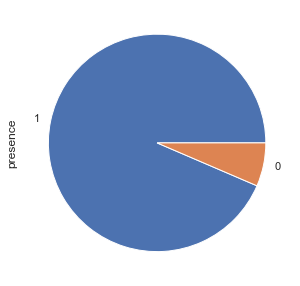

In [118]:
df['presence'].value_counts().plot(kind='pie',figsize=(5,5))

In [15]:
# msno.matrix(df,figsize=(12,5));

In [16]:
def val_by_presence(value):
    sns.boxplot(x='presence',y=value,data=df)
    
wgts.Dropdown(
    options=numeric_columns,
    value=numeric_columns[0],
    description='Number:',
    disabled=False,
)
wgts.interact(val_by_presence, value = numeric_columns);

interactive(children=(Dropdown(description='value', options=('tmin', 'tmax', 'tmean', 'precip', 'sm', 'vegetat…

In [17]:
# def val_by_presence(value):
#     sns.boxplot(x='perc_numeric',y=value,data=df)
    
# wgts.Dropdown(
#     options=numeric_columns,
#     value=numeric_columns[0],
#     description='Number:',
#     disabled=False,
# )
# wgts.interact(val_by_presence, value = numeric_columns);

# Logistic Regression

In [18]:
# define min max scaler
scaler = MinMaxScaler()

In [19]:
X = df[numeric_columns].values

In [20]:
y = df.presence.values

In [21]:
X.size, y.size

(26940, 4490)

In [22]:
sorted(Counter(y).items())

[(0, 290), (1, 4200)]

In [23]:
rus = RandomUnderSampler(random_state=0)

In [24]:
X_resampled, y_resampled = rus.fit_resample(X, y)
sorted(Counter(y_resampled).items())

[(0, 290), (1, 290)]

In [25]:
# transform data
# X_scaled = scaler.fit_transform(X)
X_scaled = scaler.fit_transform(X_resampled)

In [26]:
# x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.2,random_state=75)
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y_resampled,test_size=0.2,random_state=75)
# y_train = y_train.reshape(-1,1)
# y_test = y_test.reshape(-1,1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [27]:
print(f"""
        x_train's shape is {x_train.shape} 
        x_test's shape is {x_test.shape}
        y_train's shape is {y_train.shape}
        y_test's shape is  {y_test.shape}
""")


        x_train's shape is (464, 6) 
        x_test's shape is (116, 6)
        y_train's shape is (464, 1)
        y_test's shape is  (116, 1)



In [132]:
x_train

array([[0.4380864 , 0.12147805, 0.32549205, 0.        , 0.35959747,
        0.14107884],
       [0.40287224, 0.09328168, 0.29218969, 0.        , 0.24555859,
        0.13692946],
       [0.22676052, 0.07666504, 0.16717062, 0.        , 0.42349093,
        0.1846473 ],
       ...,
       [0.78092996, 0.60108631, 0.71819909, 1.        , 0.60128405,
        0.60995851],
       [0.66014676, 0.53216878, 0.6132502 , 0.03142829, 0.62403818,
        0.4813278 ],
       [0.33542758, 0.01968034, 0.22186083, 0.        , 0.24910243,
        0.17842324]])

In [133]:
lr_model = LogisticRegression()
lr_model.fit(x_train,y_train);

Feature: 0, Score: -2.05564
Feature: 1, Score: 1.28724
Feature: 2, Score: -0.96649
Feature: 3, Score: -2.79665
Feature: 4, Score: 0.13521
Feature: 5, Score: -0.59077


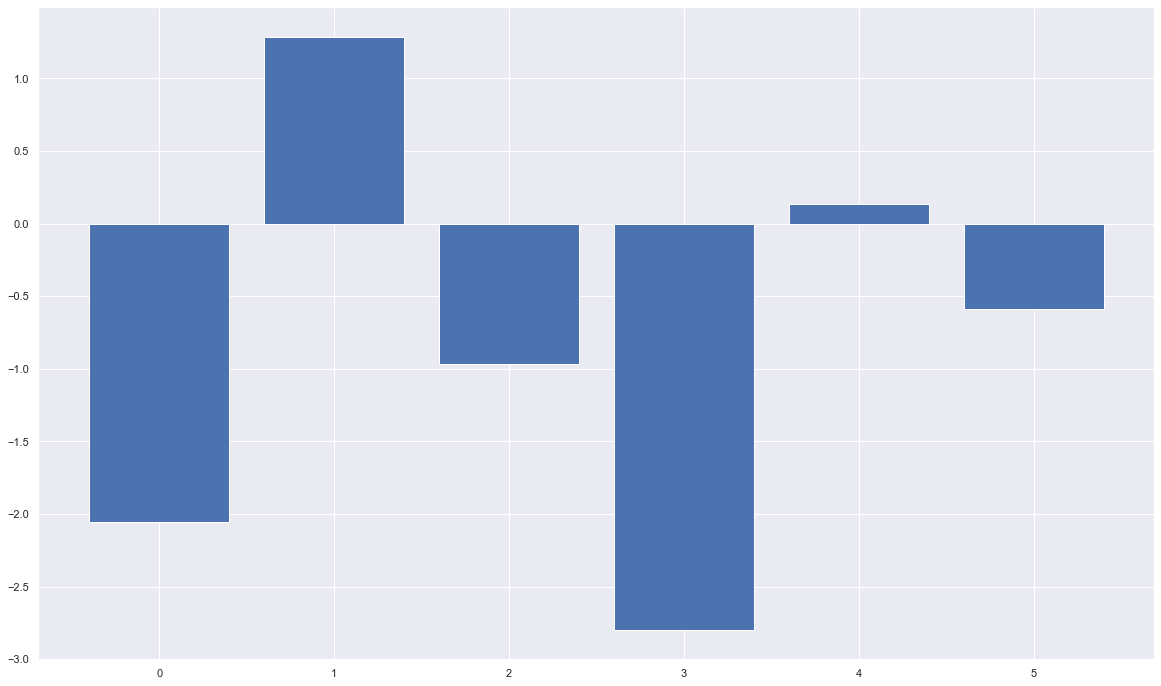

In [134]:
# get importance
importance = lr_model.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
plt.bar([x for x in range(len(importance))], importance);

In [13]:
# numeric_columns

<b>Classification problem with classes 0 and 1, coefficients are both positive and negative. \
The positive scores indicate a feature that predicts class 1, whereas the negative scores indicate a feature that predicts class 0.</b>

In [14]:
print("Model's score ", lr_model.score(x_test,y_test))

NameError: name 'lr_model' is not defined

In [ ]:
predictions = lr_model.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
accuracy

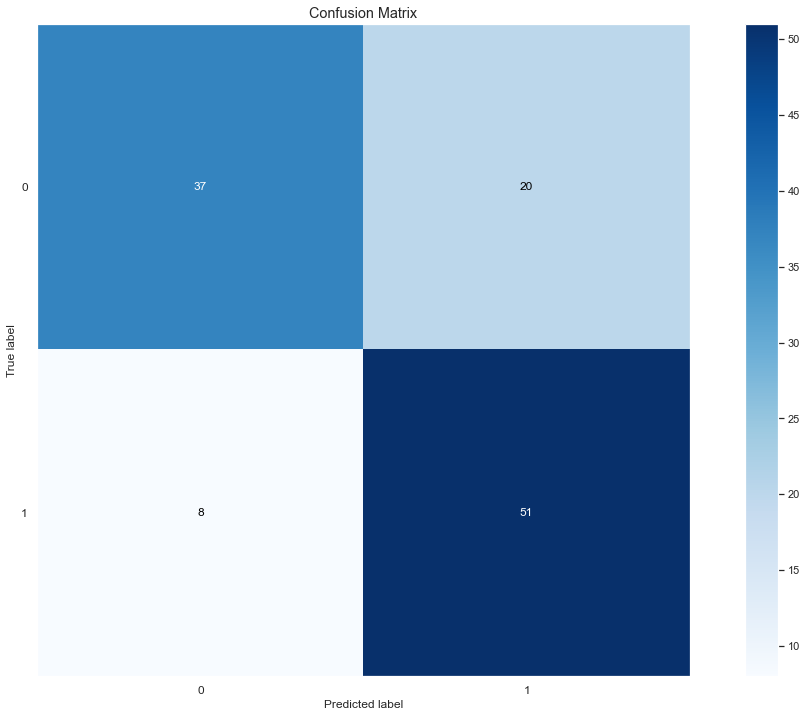

In [138]:
skplt.metrics.plot_confusion_matrix(y_true=y_test, y_pred=predictions);

In [152]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.65      0.73        57
           1       0.72      0.86      0.78        59

    accuracy                           0.76       116
   macro avg       0.77      0.76      0.76       116
weighted avg       0.77      0.76      0.76       116



In [140]:
y_proba = lr_model.predict_proba(x_test)

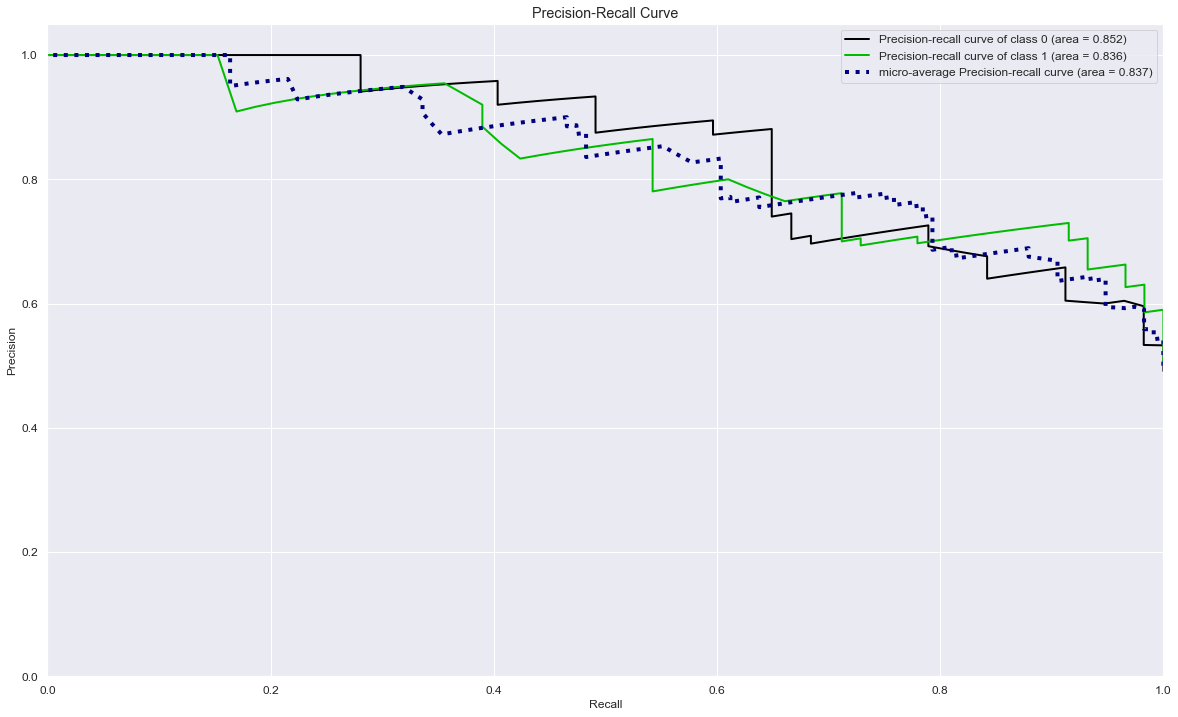

In [141]:
skplt.metrics.plot_precision_recall(y_true=y_test, y_probas=y_proba);

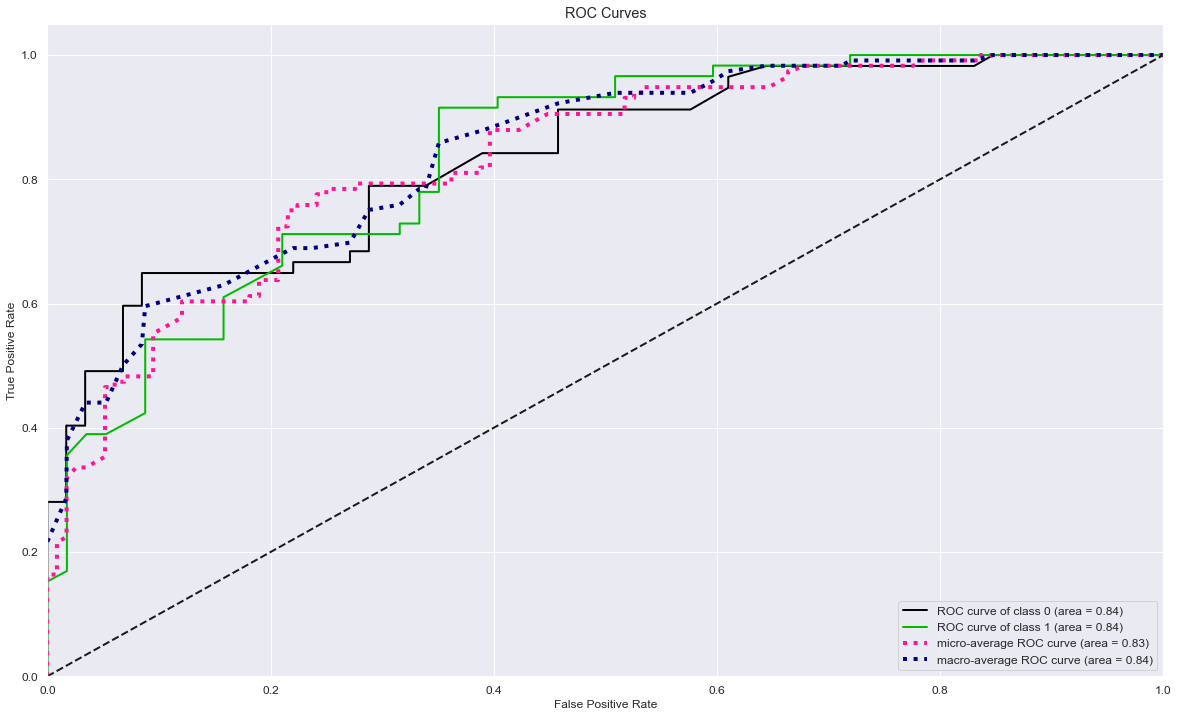

In [142]:
skplt.metrics.plot_roc_curve(y_test, y_proba);

# RandomForest

https://machinelearningmastery.com/random-forest-ensemble-in-python/

In [143]:
clf = RandomForestClassifier() #n_estimators = 500)

In [144]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.959 (0.009)


In [145]:
clf.fit(x_train, y_train)

RandomForestClassifier()

In [146]:
y_pred = clf.predict(x_test)

In [147]:
print("Accuracy Score: ", accuracy_score(y_test, y_pred))

Accuracy Score:  0.8275862068965517


In [148]:
clf.predict([[0.1, 0.13, 0.2, 0.2, 0.3, 0.2]])

array([1], dtype=int64)

In [149]:
feature_imp = pd.Series(clf.feature_importances_, index = numeric_columns).sort_values(ascending = False)
feature_imp

vegetation    0.314079
sm            0.211232
precip        0.147437
tmin          0.141329
tmean         0.100356
tmax          0.085568
dtype: float64

<AxesSubplot:>

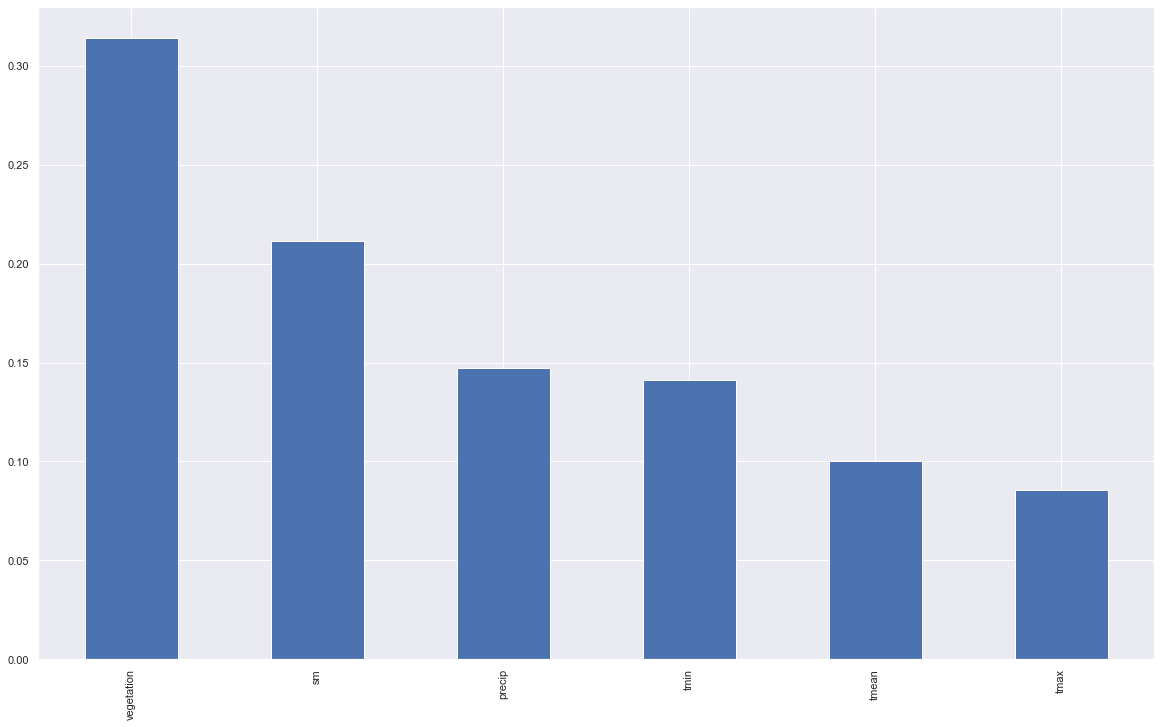

In [150]:
feature_imp.plot(kind='bar')